# Model
## 6.A Performance Measures
We use area under the receiver operating characteristic curve (AUC) as our main performance measure. We believe that in case of medical diagnostics for non-life threatening terminal diseases like most neurodegenerative diseases it is important to have a high true positive rate so that all patients with alzheimer's are identified as early as possible. But we also want to make sure that the false positive rate is as low as possible since we do not want to misdiagnose a healthy adult as demented and begin medical therapy. Hence AUC seemed like a ideal choice for a performance measure.

We will also be looking at accuracy and recall for each model.

In the figure below, you can think relevant elements as actually demented subjects. Precision and Recall [12]

![image](https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg)

## 6.B Logistic Regression
The parameter C, inverse of regularization strength.

Tuning range: [0.001, 0.1, 1, 10, 100]

In [15]:
import joblib
import argparse
import sys
import os
from azureml.core import Run, Dataset, Workspace, Experiment
#hello
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set()


# Load the workspace from the saved config file
ws = Workspace(subscription_id="9ce8d68a-39d6-47d5-b01d-baf594538731",
               resource_group="PracticeSquadTrain",
               workspace_name="MLSquad"
               )


# Repeatable Model 

In [16]:
def buildpreprocessorpipeline(X_raw):
    categorical_features = X_raw.select_dtypes(
        include=['object', 'bool']).columns
    numeric_features = X_raw.select_dtypes(include=['float', 'int64']).columns

    categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value="missing")),
                                              ('onehotencoder', OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore'))])

    numeric_transformer1 = Pipeline(
        steps=[('scaler1', SimpleImputer(missing_values=np.nan, strategy='mean'))])
    #numeric_transformer2 = Pipeline(steps=[('scaler2', StandardScaler(with_mean=True))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric1', numeric_transformer1, numeric_features),
            ('categorical', categorical_transformer, categorical_features)
        ], remainder="drop")

    return preprocessor


def model_train(LABEL, df, run):
    y_raw = df[LABEL]
    X_raw = df.drop([LABEL], axis=1)
    print(X_raw.columns)
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.2, random_state=0)

    #use Logistic Regression estimator from scikit learn
    lg = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
    preprocessor = buildpreprocessorpipeline(X_train)

    #estimator instance
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', lg)])

    model = clf.fit(X_train, y_train)

    # calculate AUC
    y_scores = model.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_scores[:, 1])
    print('AUC: ' + str(auc))
    run.log('AUC', np.float(auc))

    # calculate test accuracy
    y_hat = model.predict(X_test)
    acc = np.average(y_hat == y_test)
    print('Accuracy:', acc)
    run.log('Accuracy', np.float(acc))

    # plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_scores[:, 1])
    fig = plt.figure(figsize=(6, 4))
    # Plot the diagonal 50% line
    plt.plot([0, 1], [0, 1], 'k--')
    # Plot the FPR and TPR achieved by our model
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    run.log_image(name="ROC", plot=fig)
    plt.show()

    # plot confusion matrix
    # Generate confusion matrix
    cmatrix = confusion_matrix(y_test, y_hat)
    cmatrix_json = {
        "schema_type": "confusion_matrix",
        "schema_version": "v1",
        "data": {
            "class_labels": ["0", "1"],
            "matrix": [
                [int(x) for x in cmatrix[0]],
                [int(x) for x in cmatrix[1]]
            ]
        }
    }

    run.log_confusion_matrix('ConfusionMatrix_Test', cmatrix_json)

    return model
    # Save the trained model


Starting experiment: Alz_Dem
Index(['Subject ID', 'Group', 'MR Delay', 'M/F', 'Age', 'EDUC', 'SES', 'MMSE',
       'CDR', 'eTIV', 'nWBV', 'ASF'],
      dtype='object')
Index(['Subject ID', 'MR Delay', 'M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR',
       'eTIV', 'nWBV', 'ASF'],
      dtype='object')
AUC: 0.9285714285714285
Accuracy: 0.9


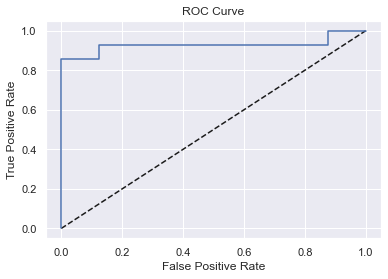

Model trained and registered.


In [17]:
def main():
    # Create an Azure ML experiment in your workspace
    experiment = Experiment(workspace=ws, name='Alz_Dem')
    run = experiment.start_logging()
    print("Starting experiment:", experiment.name)

    #df = pd.read_csv('./train/data.csv')
    df = pd.read_csv('./Data/oasis_longitudinal.csv')
    # use first visit data only because of the analysis we're doing
    df = df.loc[df['Visit'] == 1]
    df = df.reset_index(drop=True)  # reset index after filtering first visit data
    df['M/F'] = df['M/F'].replace(['F', 'M'], [0, 1])  # M/F column
    df['Group'] = df['Group'].replace(
        ['Converted'], ['Demented'])  # Target variable
    df['Group'] = df['Group'].replace(
        ['Demented', 'Nondemented'], [1, 0])  # Target variable
    df = df.drop(['MRI ID', 'Visit', 'Hand'], axis=1)  # Drop unnecessary columns

    print(df.columns)

    model = model_train('Group', df, run)

    os.makedirs('outputs', exist_ok=True)
    # note file saved in the outputs folder is automatically uploaded into experiment record

    model_file = 'outputs/titanic_model.pkl'
    joblib.dump(value=model, filename=model_file)

    run.complete()

    # Register the model
    run.register_model(model_path=model_file, model_name='Alz_Dem-model',
                       tags={'Model Type': 'Logistic Regresssion'})

    print('Model trained and registered.')


if __name__ == "__main__":
    main()
